# GA 기반 정비 스케줄링 최적화
2022.04.24 민수홍

GA를 활용한 정비스케줄링

## Library

In [1]:
### library
requiredPackages = c('tidyverse', 'GA')

for(p in requiredPackages){
  if(!require(p,character.only = TRUE)) install.packages(p)
  library(p,character.only = TRUE)
}


Loading required package: tidyverse

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

√ ggplot2 3.3.5     √ purrr   0.3.4
√ tibble  3.0.2     √ dplyr   1.0.0
√ tidyr   1.1.0     √ stringr 1.4.0
√ readr   1.3.1     √ forcats 0.5.0

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: GA

Warning message:
"package 'GA' was built under R version 4.0.3"
Loading required package: foreach

Warning message:
"package 'foreach' was built under R version 4.0.3"

Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Loading required package: iterators

Package 'GA' version 3.2
Type 'citation("GA")' for citing this R package in publications.


Attaching package: 'GA'


The following object is masked from 'package

In [7]:
work_path = 'D:\\Google 드라이브\\연구실\\SKT fellowship'
setwd(work_path)

risk_info = read.csv('data\\risk_cdf.csv') # Dataset

## Risk Information Visualization

In [15]:
options(repr.plot.width=9, repr.plot.height=7)

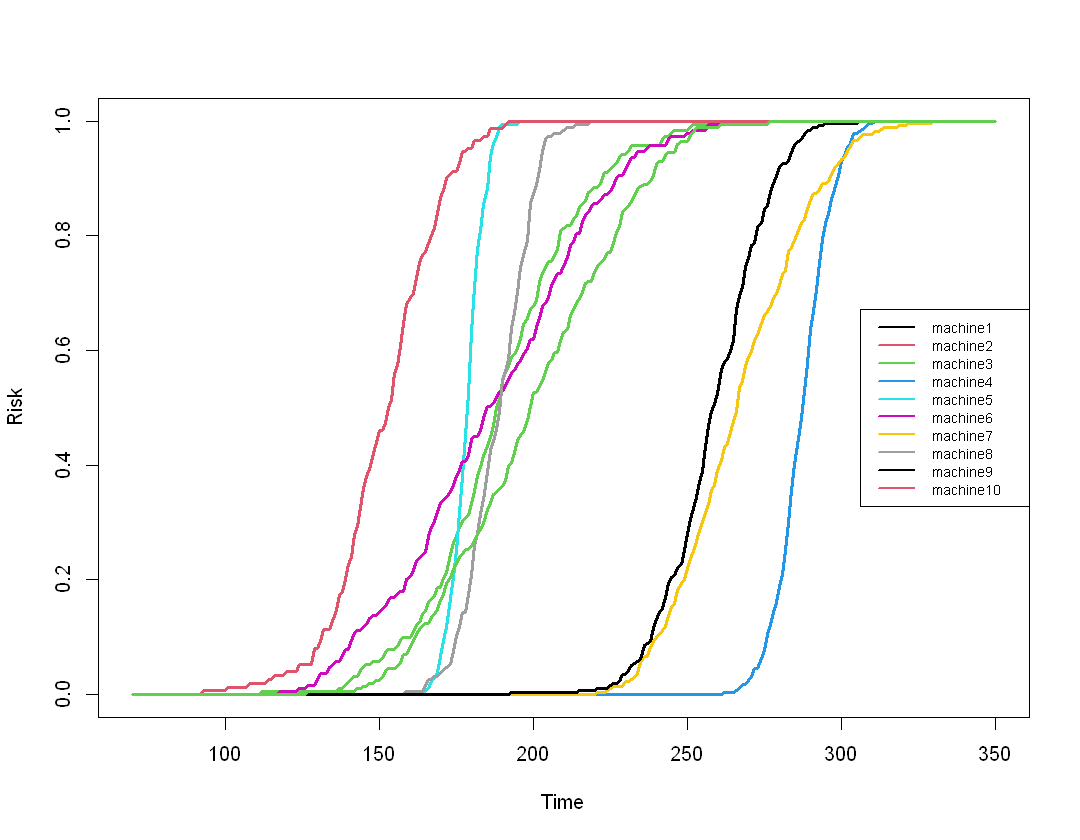

In [16]:
par(mfrow = c(1,1))
plot(risk_info[70:350, 1], risk_info[70:350,2] , type = 'l', lwd = 3, 
     xlab = 'Time', ylab = 'Risk', col = 1)
for (i in 2:10) {
  lines(risk_info[70:350,1], risk_info[70:350,i], type = 'l', lwd = 3, col = i + 1)
}
legend('right', c('machine1', 'machine2', 'machine3', 'machine4', 'machine5', 
                  'machine6', 'machine7', 'machine8', 'machine9', 'machine10'),
       col = seq(1:10), lwd = 2, cex = 0.7)

## GA 기반 스케줄링

In [18]:
risk_info = risk_info[,-1] # 필요없는 열 제거

In [19]:
con2binary = function(x) {
    # 0~1 사이의 값을 x를 넘으면 1, 안넘으면 0으로 변환
  x = as.numeric(x)
  x[x >= binary_cri] = 1
  x[x <= binary_cri] = 0
  
  return(x)
}

In [24]:
fitness = function(x) {
  
  # gary to binary
  x = con2binary(x)
  
  if(sum(x) > 1) { # 특성 시간대에 2대 이상의 설비를 점검하지 않는다
    return(0)
  } else {
    risk = x %*% t(current_data) + ((x %*% t(current_data)) - 0.1)
    if(risk <= 0) {
      return(0)
    } else {
      return(risk)
    }
  }
}

In [23]:
binary_cri = 0.998
solution_mat = c()

for (time in 1:200) {
  current_data = risk_info[time, ]
  
  GA = ga(type = 'real-valued', fitness = fitness, nBits = ncol(risk_info), maxiter = 20,
          lower = rep(0,100), upper = rep(1,100),
          popSize = 50, keepBest = FALSE)
  
  solution = GA@solution[1,] # 같은 fitness를 가지면 여러개의 행이 생김
  
  solution = con2binary(solution)
  
  solution_mat = rbind(solution_mat, solution)
  
  risk_info[(time + 1):nrow(risk_info), which(solution == 1)] = 0 # 점검이 실행되면 이후 Risk = 0
  if (time %% 10 == 0)
    print(c("iteration : ", time))
}

[1] "iteration : " "10"          
[1] "iteration : " "20"          
[1] "iteration : " "30"          
[1] "iteration : " "40"          
[1] "iteration : " "50"          


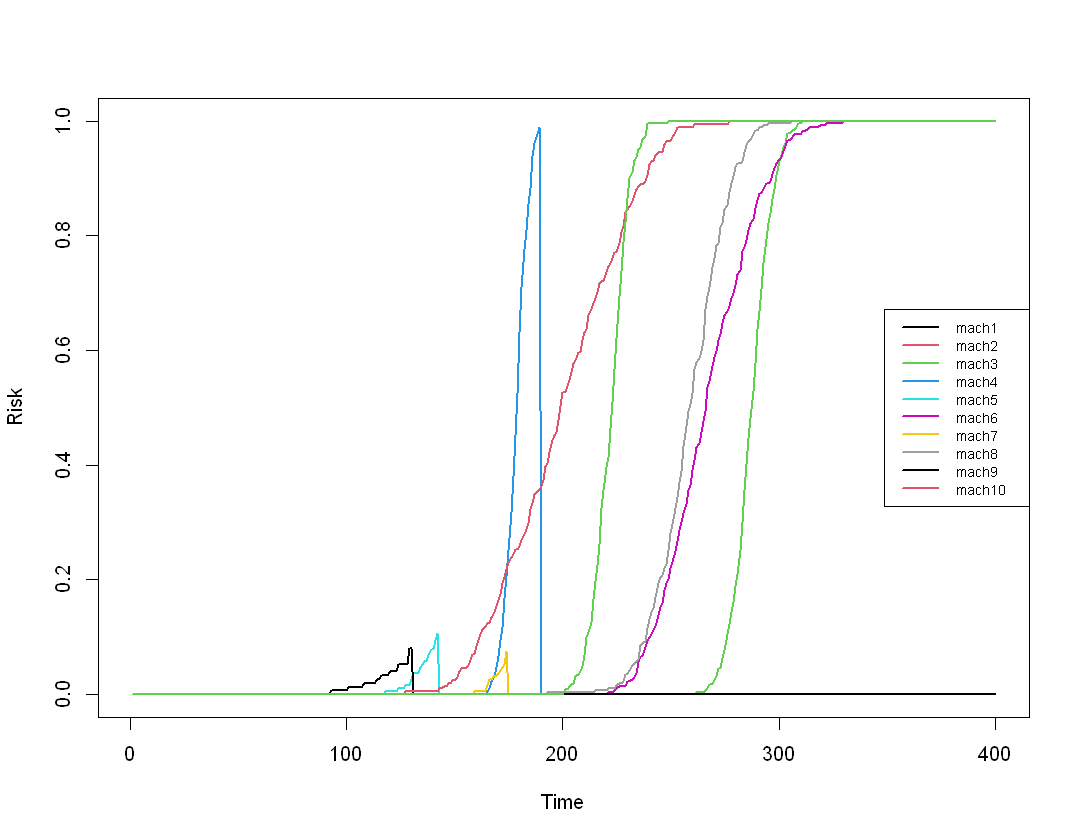

In [22]:
par(mfrow = c(1,1))
plot(1:nrow(risk_info), risk_info[,2] , type = 'l', lwd = 2, 
     xlab = 'Time', ylab = 'Risk', col = 1,
     ylim = c(0,1))
for (i in 2:10) {
  lines(1:nrow(risk_info), risk_info[,i], type = 'l', lwd = 2, col = i + 1)
}
legend('right', c('mach1', 'mach2', 'mach3', 'mach4', 'mach5', 'mach6', 'mach7',
                  'mach8', 'mach9', 'mach10'),
       col = seq(1:10), lwd = 2, cex = 0.7)